# Import 


In [1]:
import sys
print(sys.version)

In [2]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import torch
import torch.nn.functional as F                          # Functions like ReLU
import torch.optim as optim                              # Optimizers like Adam
import torch.nn as nn                                    # Neural Network Modules
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2            # Coverting image to Tensor
from tqdm import tqdm                                    # To print the Progress bar

# Create/process data

In [3]:
os.getcwd()

In [3]:
train_data_path = "../input/cat-and-dog/training_set/training_set"
test_data_path="../input/cat-and-dog/test_set/test_set"

In [4]:
# we will create a class that helps us obtain the dataset first then transforms the dataset
class Data(Dataset):
    def __init__(self, data_directory, typee='train', transforms=None):
        catpaths = data_directory+'/cats'
        dogpaths = data_directory+'/dogs'
        cats = os.listdir(catpaths) # this gives list of images of cats in datapath
        dogs = os.listdir(dogpaths) # this gives list of images of dogs in datapath
        # list comprehension
        self.images = [(catpaths+'/'+cats[i],0) for i in range(len(cats)) if cats[i].endswith('.jpg')] # this line responsible for obtaining all cat images
        dogs = [(dogpaths+'/'+dogs[i],1) for i in range(len(dogs)) if dogs[i].endswith('.jpg')] # this line responsible for obtaining all dog images
        self.transforms = transforms # this line will be responsible to transforms/normalize our cat images
        self.images.extend(dogs) # this line include dog images
        
    def __len__(self):
        return len(self.images) # number of pictures
    
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index][0]))
        y = self.images[index][1]
        if self.transforms is not None:
            augmentations = self.transforms(image=img)
            img = augmentations["image"]
        return img,y

# Process image

In [5]:
# this cell is responsible for creating transform pipeline for our images
import albumentations as A
transform = A.Compose([
    A.Resize(224,224),
    A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # same as Pytorch documentation
    ToTensorV2()
])

# Form Dataset

In [6]:
def DOGCAT_Dataset(image_directory, transforms=None, batch_size=1, shuffle=True, pin_memory=True, train=True):
    data = Data(image_directory, transforms=transform) # call the class above to get images of cat and dog
    if train == False:
        return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    
    # if train == true, we split the dataset into train and test
    train_size = int(0.8 * data.__len__()) # 80 percent of data goes to training
    test_size = data.__len__() - train_size # total number of images minus train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_data = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_data,test_data


In [7]:
train_data,test_data = DOGCAT_Dataset(train_data_path,transforms=transform,batch_size=16,shuffle=True,pin_memory=True)

In [8]:
# Transposing the tensors to visualize image
for i,j in train_data:
    # i[0,:,:,:] -> rgb images
    img = np.transpose(i[0,:,:,:], (1,2,0))
    print(j)
    plt.imshow(img)
    break

# Convolutional Model

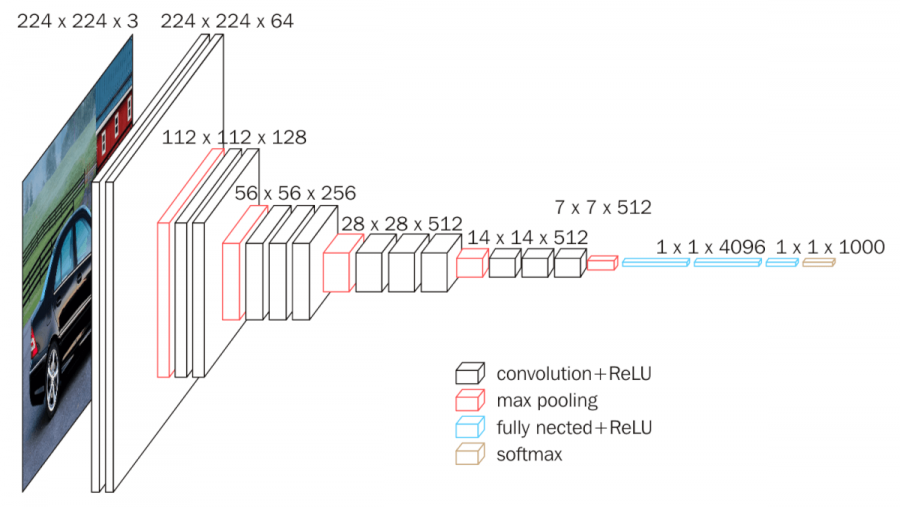

In [9]:
# Notice the above picture that we have mulitiple conv layers, we will create a class that create multiple conv layers!
class N_conv(nn.Module):
    def __init__(self, in_channels, out_channels, N=2):
        super(N_conv, self).__init__() # inheritance
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding=(1,1)))
        model.append(nn.ReLU(True))
        for i in range(N-1):
            model.append(nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), padding=(1,1)))
            model.append(nn.ReLU(True))
        model.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
        self.conv = nn.Sequential(*model)
    def forward(self,x):
        return self.conv(x)

In [10]:
class Vgg16(nn.Module):
    def __init__(self,in_channels=3,out_channels=1,init_weights=True):
        super(Vgg16,self).__init__()
        self.conv1 = N_conv(3,64) # call the above class with 3 channels and out 64 channels N times!
        self.conv2 = N_conv(64,128)
        self.conv3 = N_conv(128,256,N=3) # 3 blocks of (in_channel=128, out_channel=256)
        self.conv4 = N_conv(256,512,N=3) # 3 blocks of (in_channel=256, out_channel=512)
        self.conv5 = N_conv(512,512,N=3) # 3 blocks of (in_channel=512, out_channel=512)
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))
        self.linear1 = nn.Linear(512*7*7,4096)
        self.linear2 = nn.Linear(4096,4096)
        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout(0.3)
        self.linear3 = nn.Linear(4096,2) # 2 classes
        if init_weights:
            self._initialize_weights()
            
    def _initialize_weights(self): # function that initialize_weights of our model
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu') # Fills the input Tensor with values drawn from the normal distribution
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

# Training

In [11]:
# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [12]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 10

# Our Model

In [13]:
# 3 -> rgb channels, 2 -> two classes(dog and cat)

model = Vgg16(3,2).to(device)



In [14]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_data), total=len(train_data)) # tqdm to display the bar
    loss = 0
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        # backward
        optimizer.zero_grad()
        
        scores = model(data)
        loss = loss_function(scores, targets)
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
        #Update Progress bar to display
        loop.set_description(f'Epoch [{epoch+1}]')
        loop.set_postfix(loss = loss.item())

In [16]:
def evaluate_images(dataset, model):
    correct = 0
    samples = 0
    model.eval()
    
    with torch.no_grad(): # when evaluating, no gradient
        for x, y in dataset:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            correct += (predictions == y).sum()
            samples += predictions.size(0)
            
    model.train()
    return correct / samples
    
    

In [17]:
evaluate_images(train_data, model)

<b>Training model has 92% accuracy </b>

In [18]:
evaluate_images(test_data, model)

<b>Validation model has 82% accuracy</b>

# Save/ Load model


In [19]:
# Save model

torch.save(model.state_dict(), "checkpoint.pth")

# Load
checkpoint = torch.load("./checkpoint.pth")
model.load_state_dict(checkpoint)


# Showing some sample validation images

In [20]:
test_samples = ["test_set/test_set/cats/cat.4029.jpg",
                "test_set/test_set/cats/cat.4027.jpg",
                "test_set/test_set/cats/cat.4030.jpg",
                "test_set/test_set/dogs/dog.4014.jpg",
                "test_set/test_set/dogs/dog.4015.jpg",
                "test_set/test_set/dogs/dog.4016.jpg",
               "test_set/test_set/dogs/dog.4030.jpg"]


In [21]:
# using list comprehension
img_list = [Image.open("../input/cat-and-dog/" + img_path) for img_path in test_samples]


data_transforms = {
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}


validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()


fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Cat, {:.0f}% Dog".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)